In [1]:
import pandas as pd
import numpy as np
import matplotlib as pyplot
from datetime import datetime

In [22]:
df = pd.read_csv("april.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9433 entries, 0 to 9432
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tanggal     9433 non-null   object
 1   waktu       9433 non-null   object
 2   ketinggian  9433 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 221.2+ KB


In [23]:
df.describe()

,ketinggian
count,9433.000000
mean,110.825718
std,54.422772
min,-33.000000
25%,73.000000
50%,115.000000
75%,149.000000
max,262.000000


In [24]:
df.duplicated().sum()

0

In [3]:
#ubah menjadi datetime
df['tanggal'] = pd.to_datetime(df['tanggal'], format='%d/%m/%Y')
df['waktu'] = pd.to_datetime(df['waktu'], format='%H:%M:%S').dt.time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9433 entries, 0 to 9432
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tanggal     9433 non-null   datetime64[ns]
 1   waktu       9433 non-null   object        
 2   ketinggian  9433 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 221.2+ KB


In [4]:
# gabung
df['waktu1'] = df.apply(lambda row: datetime.combine(row['tanggal'], row['waktu']), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9433 entries, 0 to 9432
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tanggal     9433 non-null   datetime64[ns]
 1   waktu       9433 non-null   object        
 2   ketinggian  9433 non-null   int64         
 3   waktu1      9433 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 294.9+ KB


In [5]:
# Menghapus kolom 'tanggal' dan 'waktu' yang lama
df.drop(columns=['tanggal', 'waktu'], inplace=True)
df

,ketinggian,waktu1
0,93,2023-04-01 00:00:00
1,129,2023-04-01 01:00:00
2,153,2023-04-01 02:00:00
3,160,2023-04-01 03:00:00
4,159,2023-04-01 04:00:00
...,...,...
9428,63,2024-04-30 19:00:00
9429,83,2024-04-30 20:00:00
9430,100,2024-04-30 21:00:00
9431,116,2024-04-30 22:00:00


In [6]:
#cek data hilang
df.isnull().sum()

ketinggian    0
waktu1        0
dtype: int64

<Axes: ylabel='ketinggian'>

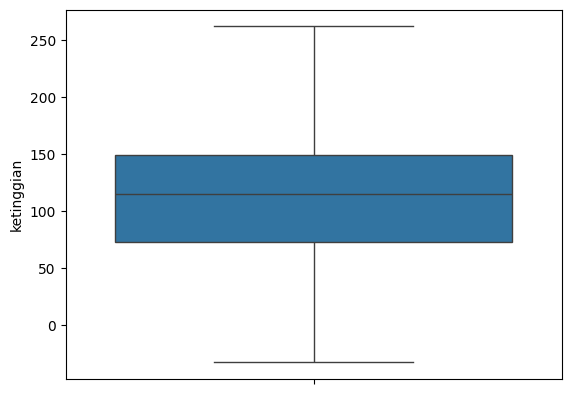

In [7]:
#cek outlier
import seaborn as sns
sns.boxplot(y=df['ketinggian'])

In [8]:
# hitung data training dengan data testing
utrain = int(len(df) * 0.8)
utest = len(df) - utrain
utest

1887

In [9]:
# pisah data training dan data testing
train = df.iloc[:7546]
test = df.iloc[7546:]
train

,ketinggian,waktu1
0,93,2023-04-01 00:00:00
1,129,2023-04-01 01:00:00
2,153,2023-04-01 02:00:00
3,160,2023-04-01 03:00:00
4,159,2023-04-01 04:00:00
...,...,...
7541,118,2024-02-12 04:00:00
7542,151,2024-02-12 05:00:00
7543,150,2024-02-12 06:00:00
7544,144,2024-02-12 07:00:00


In [10]:
#normalisasi training dan testing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train[['ketinggian']])
test = scaler.fit_transform(test[['ketinggian']])
test

array([[0.58461538],
       [0.53076923],
       [0.47307692],
       ...,
       [0.47692308],
       [0.53846154],
       [0.57307692]])

In [11]:
# Uji Augmented Dickey-Fuller (ADF) untuk stasioneritas
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

result = adfuller(df['ketinggian'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] <= 0.05:
    print("Hasil uji menunjukkan data tidak stasioner (ada tren).")
else:
    print("Hasil uji menunjukkan data stasioner (tanpa tren).")

ADF Statistic: -3.398124521210949
p-value: 0.011022972945383866
Critical Values:
   1%: -3.431046304852604
   5%: -2.861847723138913
   10%: -2.566933795935773
Hasil uji menunjukkan data tidak stasioner (ada tren).


In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

best_rmse = float('inf')
best_period = None
possible_periods = [7, 14, 30, 60, 90, 144, 180, 365]


for period in possible_periods:
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=period)
    fit = model.fit(smoothing_level=0.6,
    smoothing_trend=2e-5,
    smoothing_seasonal=0.001)
    predictions = fit.predict(start=len(train), end=len(train)+len(test)-1)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_period = period

print(f"Best seasonal_periods: {best_period}")


Best seasonal_periods: 144


In [25]:
# Membuat model Exponential Smoothing dengan tuning hyperparameters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=144
)

fit = model.fit(
    smoothing_level=0.6,
    smoothing_trend=2e-5,
    smoothing_seasonal=0.001
)

fit

In [14]:
prediksi = fit.forecast(steps=len(test))
prediksi

array([0.58633556, 0.59485329, 0.59171135, ..., 0.49349445, 0.53273971,
       0.57202467])

In [15]:
from sklearn import metrics
mae = metrics.mean_absolute_error(test, prediksi)
mse = metrics.mean_squared_error(test, prediksi)
rmse = np.sqrt(mse)
print (mae)
print (mse)
print (rmse)

0.152132921898121
0.035151776044066566
0.187488069071252


In [16]:
#balikkin ke data asli 
trainasli = scaler.inverse_transform(train)
testasli = scaler.inverse_transform(test)
prediksi = prediksi.reshape(-1,1)
prediksiasli = scaler.inverse_transform(prediksi)
trainasli

array([[ 87.05084746],
       [118.77966102],
       [139.93220339],
       ...,
       [137.28813559],
       [132.        ],
       [124.06779661]])

In [17]:
#reshape data
trainasli = trainasli.reshape(-1)  # atau gunakan .ravel()
testasli = testasli.reshape(-1)
futureasli = prediksiasli.reshape(-1)

train_len = len(train)
test_len = len(test)
train_index = np.arange(0, train_len)
test_index = np.arange(train_len, train_len + test_len)

trains = pd.DataFrame(trainasli, index=train_index)
tests = pd.DataFrame(testasli, index=test_index)
prediksi = pd.DataFrame(futureasli, index=test_index)

In [18]:
gabungan = pd.concat([trains, prediksi, tests, df['waktu1']], axis=1)
gabungan.columns = ['Train', 'Prediksi', 'Test', 'waktu']
gabungan

,Train,Prediksi,Test,waktu
0,87.050847,NaN,NaN,2023-04-01 00:00:00
1,118.779661,NaN,NaN,2023-04-01 01:00:00
2,139.932203,NaN,NaN,2023-04-01 02:00:00
3,146.101695,NaN,NaN,2023-04-01 03:00:00
4,145.220339,NaN,NaN,2023-04-01 04:00:00
...,...,...,...,...
9428,NaN,93.464466,63.0,2024-04-30 19:00:00
9429,NaN,96.859212,83.0,2024-04-30 20:00:00
9430,NaN,104.308558,100.0,2024-04-30 21:00:00
9431,NaN,114.512325,116.0,2024-04-30 22:00:00


In [19]:
gabungan.to_csv('ses_tableau.csv', index=False)